In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import scipy.optimize
import matplotlib.pyplot as plt
#import torch
from modelling_fctns import double_logistic, normalized_difference
import data_cleaning
import LSP

import libtlda.tca

import adapt.feature_based

import cv2
from PIL import Image

import scipy.signal
from scipy.interpolate import make_smoothing_spline
#

In [2]:
import skfda
from skfda.misc.hat_matrix import (
    KNeighborsHatMatrix,
    LocalLinearRegressionHatMatrix,
    NadarayaWatsonHatMatrix,
)
from skfda import FDataGrid
from skfda.misc.kernels import uniform
from skfda.preprocessing.smoothing import KernelSmoother
from skfda.preprocessing.smoothing.validation import SmoothingParameterSearch

In [18]:
ds = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\earth_engine_MP\\Saved_files\\MODIS\\Kenya\\satdata0.csv')
ds = data_cleaning.add_SOS_to_df(ds)
ds = data_cleaning.add_EOS_to_df(ds)
ds['NDVI'] = normalized_difference(ds['median sur_refl_b02'], ds['median sur_refl_b01'])
max_value_interpolated = data_cleaning.map_max_value_int(ds, window_size=8)
array_input = data_cleaning.make_df_samples(max_value_interpolated, sample_number = 1000, m_window_size = 5)
sampled_locs_input = data_cleaning.make_tensor_from_timeseries(max_value_interpolated, sample_number = 100, m_window_size = 5, format_choice = 'numpy')

In [15]:
ds2 = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\earth_engine_MP\\Saved_files\\MODIS\\Germany\\satdata0.csv')
ds2 = data_cleaning.add_SOS_to_df(ds2)
ds2 = data_cleaning.add_EOS_to_df(ds2)
ds2['NDVI'] = normalized_difference(ds['median sur_refl_b02'], ds['median sur_refl_b01'])
max_value_interpolated2 = data_cleaning.map_max_value_int(ds2, window_size=8)
array_input2 = data_cleaning.make_df_samples(max_value_interpolated2, sample_number = 1000, m_window_size = 5)
sampled_locs_input2 = data_cleaning.make_tensor_from_timeseries(max_value_interpolated2, sample_number = 100, m_window_size = 5, format_choice = 'numpy')

In [18]:
def autocorrelation_matrix(ds, variable = 'NDVI', index_coord = 'index'):
    X = (ds[variable] - ds[variable].mean(dim='sample')).values
    return np.corrcoef(X.T)

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(autocorrelation_matrix(array_input, variable = 'NDVI', index_coord = 'index'), vmin = 0, vmax = 1, cmap = 'Purples')
axs[0].set_ylabel('Time in window (0 is first element)')
axs[0].set_xlabel('Time in window (0 is first element)')
axs[1].imshow(autocorrelation_matrix(array_input2, variable = 'NDVI', index_coord = 'index'), vmin = 0, vmax = 1, cmap = 'Purples')
axs[1].set_xlabel('Time in window (0 is first element)')
axs[0].set_title('Kenya')
axs[1].set_title('Germany')
fig.suptitle('Correlation between times in a window of NDVI timeseries', fontsize = 20)

In [13]:
def cross_percentile_date(smoothed_series, percentile):
    # Calculate the 90th percentile
    percentile_value = np.percentile(smoothed_series, 10)
    # Identify when the time series crosses the 90th percentile
    crosses_percentile = (smoothed_series > percentile_value).astype(int).diff().fillna(0).astype(bool)

    # Extract the dates when the crossing occurs
    crossing_dates = smoothed_series.index[crosses_percentile]
    return(crossing_dates)

def double_logistic_LSP(values, Times, first_date):
    Tighter_times = np.arange(Times[0], Times[-1], 1)
    params, _ = scipy.optimize.curve_fit(modelling_fctns.double_logistic, Times/365, values, maxfev = 10000)
    smoothed_series = pd.Series(modelling_fctns.double_logistic(Tighter_times/365, *params), index=Tighter_times/365)
    max_green = first_date + pd.Timedelta(Tighter_times[np.int64(smoothed_series.idxmax()*365)], 'D')
    percentile_10 = first_date + pd.Timedelta(cross_percentile_date(smoothed_series, 10)[0]*365, 'D')
    percentile_50 = first_date + pd.Timedelta(cross_percentile_date(smoothed_series, 50)[0]*365, 'D')
    percentile_90 = first_date + pd.Timedelta(cross_percentile_date(smoothed_series, 90)[0]*365, 'D')
    percentile_10_2nd = first_date + pd.Timedelta(cross_percentile_date(smoothed_series, 10)[-1]*365, 'D')
    return percentile_10, percentile_50, percentile_90, percentile_10_2nd, max_green

def spline_LSP(values, Times, first_date):
    Tighter_times = np.arange(Times[0], Times[-1], 1)
    spl = make_smoothing_spline(Times/365, values, lam = 0.00001)
    smoothed_series = pd.Series(spl(Tighter_times/365), index=Tighter_times/365)
    #print(Tighter_times/365, smoothed_series.idxmax(), smoothed_series)
    max_green = first_date + pd.Timedelta(Tighter_times[np.int64(smoothed_series.idxmax()*365)], 'D')
    percentile_10 = first_date + pd.Timedelta(cross_percentile_date(smoothed_series, 10)[0]*365, 'D')
    percentile_50 = first_date + pd.Timedelta(cross_percentile_date(smoothed_series, 50)[0]*365, 'D')
    percentile_90 = first_date + pd.Timedelta(cross_percentile_date(smoothed_series, 90)[0]*365, 'D')
    percentile_10_2nd = first_date + pd.Timedelta(cross_percentile_date(smoothed_series, 10)[-1]*365, 'D')
    print(spl(Tighter_times[np.int64(smoothed_series.idxmax()*365)]/365), max_green, spl(Tighter_times/365).max())
    return percentile_10, percentile_50, percentile_90, percentile_10_2nd, max_green

def savgol_LSP(values, Times, first_date):
    smoothed_series = pd.Series(scipy.signal.savgol_filter(values, window_length=6, polyorder=3, deriv=0), index=Times)
    smoothed_derivs = pd.Series(scipy.signal.savgol_filter(values, window_length=6, polyorder=3, deriv=1), index=Times)
    mingrad = first_date + pd.Timedelta(smoothed_derivs.idxmin(), 'D')
    maxgrad = first_date + pd.Timedelta(smoothed_derivs.idxmax(), 'D')
    minday = first_date + pd.Timedelta(smoothed_series.idxmin(), 'D')
    maxday = first_date + pd.Timedelta(smoothed_series.idxmax(), 'D')
    return mingrad, maxgrad, minday, maxday

def initialize_LSP_frame(LSP_method):
    if LSP_method == 'double_logistic' or LSP_method == 'spline':
        results = pd.DataFrame(columns = ['year', 'Stations_Id', 'percentile_10', 'percentile_50', 'percentile_90', 'percentile_10_2nd', 'max_green'])
    elif LSP_method == 'savgol':
        results = pd.DataFrame(columns = ['year', 'Stations_Id', 'mingrad', 'maxgrad', 'minday', 'maxday'])
    return results

def append_LSP_frame(results, LSPs):
    results.loc[-1] = LSPs
    results.index = results.index + 1
    results = results.sort_index()
    return results

#def calculate_append_LSP_frame(results, values, Times, first_date, LSP_method):
#    if LSP_method == 'double_logistic' or LSP_method == 'spline':
#        try:
#            if LSP_method == 'double_logistic':
#                LSPs = double_logistic_LSP(values, Times, first_date)
#            else:
#                LSPs = spline_LSP(values, Times, first_date)
#            results = append_LSP_frame(results, [year, station, *LSPs])
#        except:
#            print('couldn\'t compute double logistic')
#            continue
#    elif LSP_method == 'savgol':
#        try:
#            LSPs = savgol_LSP(values, Times, first_date)
#            results = append_LSP_frame(results, [year, station, *LSPs])
#        except:
#            print('couldn\'t compute savgol')
#            continue

def calculate_append_LSP_frame(results, values, Times, first_date, LSP_method, year, station):
    if LSP_method == 'double_logistic' or LSP_method == 'spline':
        if LSP_method == 'double_logistic':
            LSPs = double_logistic_LSP(values, Times, first_date)
        else:
            LSPs = spline_LSP(values, Times, first_date)
        results = append_LSP_frame(results, [year, station, *LSPs])
    elif LSP_method == 'savgol':
        LSPs = savgol_LSP(values, Times, first_date)
        results = append_LSP_frame(results, [year, station, *LSPs])
    return results


def LSP_at_stations(ds, start_year, end_year, LSP_method = 'double_logistic'):
    results = initialize_LSP_frame(LSP_method)
    print(results)
    for year in range(start_year, end_year + 1):
        print(f'Year: {year}')
        for station in ds['Stations_Id'].unique():
            ds_station = ds.loc[ds['Stations_Id'] == station]
            ds_station_year = data_cleaning.restrict_to_growing_season(ds_station, year, ds_station['SOS'].iloc[0], ds_station['EOS'].iloc[0])
            if len(ds_station_year) > 0:
                print(f'Station {station} in {year} has {len(ds_station_year)} observations')
            else:
                print(f'Station {station} in {year} has no observations')
                continue
            max_value_interpolated = data_cleaning.map_max_value_int(ds_station_year, window_size=4) #data_cleaning.
            first_date = pd.DatetimeIndex(max_value_interpolated['time']).min()
            Times = (pd.DatetimeIndex(max_value_interpolated['time']) - pd.DatetimeIndex(max_value_interpolated['time']).min()).days.values
            NDVIs = max_value_interpolated['NDVI'].values
            try:
                results = calculate_append_LSP_frame(results, NDVIs, Times, first_date, LSP_method, year, station)
            except:
                print(f'Couldn\'t compute LSP for station {station} in year {year}')
                continue
    return results

In [17]:
ds = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\earth_engine_MP\\Saved_files\\MODIS\\Germany\\satdata0_GER.csv')
ds = data_cleaning.add_EOS_to_df(ds)
ds = data_cleaning.add_SOS_to_df(ds)
ds['NDVI'] = normalized_difference(ds['median sur_refl_b02'], ds['median sur_refl_b01'])
LSP = LSP_at_stations(ds, 2020, 2021, LSP_method='spline')

Empty DataFrame
Columns: [year, Stations_Id, percentile_10, percentile_50, percentile_90, percentile_10_2nd, max_green]
Index: []
Year: 2020
Station 7501 in 2020 has 89 observations
0.6170284523923483 2020-06-10 00:00:00 0.6170284523923483
Station 7502 in 2020 has 103 observations
0.8026449184928433 2020-06-09 00:00:00 0.8026449184928433
Station 7504 in 2020 has 76 observations
0.7335935852305882 2020-06-02 00:00:00 0.7335935852305882
Station 7506 in 2020 has 86 observations
0.6247972395494382 2020-09-20 00:00:00 0.6247972395494382
Station 7507 in 2020 has 79 observations
0.5704779530792553 2020-07-27 00:00:00 0.5704779530792553
Station 7508 in 2020 has 67 observations
0.5706046066026518 2020-07-26 00:00:00 0.5706046066026518
Station 7509 in 2020 has 92 observations
0.8301679361003933 2020-09-20 00:00:00 0.8301679361003933
Station 7513 in 2020 has 99 observations
0.7669549521450703 2020-06-23 00:00:00 0.7669549521450703
Station 7516 in 2020 has 84 observations
0.7613659528633766 2020-0

In [22]:
LSP.set_index(['year', 'Stations_Id'], inplace=True)

In [26]:
ds = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\earth_engine_MP\\Saved_files\\MODIS\\Germany\\satdata0_GER.csv')
ds.drop('Unnamed: 0', axis=1, inplace=True)

In [27]:
ds['year'] = pd.DatetimeIndex(ds['formatted_time']).year


,Time,lat,lon,Stations_Id,median sur_refl_b01,median sur_refl_b02,median sur_refl_b03,median sur_refl_b04,formatted_time
0,1577836800000,54.7833,9.4333,7501,1080.0,1386.0,1118.0,1089.0,2020-01-01-00-00-00
1,1578096000000,54.7833,9.4333,7501,502.0,707.0,589.0,537.0,2020-01-04-00-00-00
2,1579392000000,54.7833,9.4333,7501,827.0,1384.0,542.0,786.0,2020-01-19-00-00-00
3,1580860800000,54.7833,9.4333,7501,546.0,1028.0,353.0,525.0,2020-02-05-00-00-00
4,1582848000000,54.7833,9.4333,7501,146.0,410.0,83.0,68.0,2020-02-28-00-00-00
...,...,...,...,...,...,...,...,...,...
15341,1669939200000,54.8000,9.6333,7569,2542.0,2068.0,3783.0,3158.0,2022-12-02-00-00-00
15342,1670716800000,54.8000,9.6333,7569,1683.0,3394.0,1963.0,1900.0,2022-12-11-00-00-00
15343,1671148800000,54.8000,9.6333,7569,3458.0,4384.0,4232.0,3730.0,2022-12-16-00-00-00
15344,1671753600000,54.8000,9.6333,7569,533.0,2399.0,608.0,705.0,2022-12-23-00-00-00


In [23]:
LSP

percentile_10 percentile_50 percentile_90 percentile_10_2nd  \
year Stations_Id                                                               
2021 7569           2021-07-26    2021-07-26    2021-07-26        2021-09-29   
     7568           2021-07-22    2021-07-22    2021-07-22        2021-08-13   
     7566           2021-05-12    2021-05-12    2021-05-12        2021-08-04   
     7565           2021-04-16    2021-04-16    2021-04-16        2021-06-15   
     7564           2021-07-21    2021-07-21    2021-07-21        2021-08-12   
...                        ...           ...           ...               ...   
2020 7507           2020-10-10    2020-10-10    2020-10-10        2020-11-02   
     7506           2020-04-04    2020-04-04    2020-04-04        2020-10-29   
     7504           2020-08-01    2020-08-01    2020-08-01        2020-08-30   
     7502           2020-07-08    2020-07-08    2020-07-08        2020-10-23   
     7501           2020-04-05    2020-04-05    2020-04-05        2020-10-18   

                  max_green  
year Stations_Id             
2021 7569        2021-06-21  
     7568        2021-06-29  
     7566        2021-06-27  
     7565        2021-09-10  
     7564        2021-06-15  
...                     ...  
2020 7507        2020-07-27  
     7506        2020-09-20  
     7504        2020-06-02  
     7502        2020-06-09  
     7501        2020-06-10  

[100 rows x 5 columns]

In [19]:
def plot_many_NDVI_curves(ds, year, shift = 0, font_size = 15):
    fig, axs = plt.subplots(10, 1, figsize = (4, 20))
    for location_index in range(10): #[4, 5, 6, 7, 8, 9]:#[3, 5, 6, 7, 9, 10, 12]:#[3, 4, 6, 7, 8, 9, 10, 12]:#[3, 4, 5, 6, 7, 8, 9, 10, 12]:#[20, 21, 23, 27]:# range(shift, shift + 10):#:#:
        latlon = ds.loc[:, ['lat', 'lon']].drop_duplicates().iloc[location_index]
        ds_station = ds.loc[(ds['lat'] == latlon['lat']) & (ds['lon'] == latlon['lon'])]
        #print(data_cleaning.WC_EOS(latlon['lon'], latlon['lat']), data_cleaning.WC_SOS(latlon['lon'], latlon['lat']))
        #print(len(ds_station))
        #ds_station = ds.loc[(ds['Stations_Id'] == station)]
        ds_year = data_cleaning.restrict_to_growing_season(ds_station, year, data_cleaning.WC_SOS(latlon['lon'], latlon['lat']), data_cleaning.WC_EOS(latlon['lon'], latlon['lat']))
        try:
            max_value_interpolated = data_cleaning.map_max_value_int(ds_year, window_size=4) #data_cleaning.
        except:
            continue
        print(location_index, latlon, max_value_interpolated['time'].loc[max_value_interpolated['NDVI'].idxmax()])
        Times = (pd.DatetimeIndex(max_value_interpolated['time']) - pd.DatetimeIndex(max_value_interpolated['time']).min()).days.values
        Tighter_times = np.arange(Times[0], Times[-1])
        NDVIs = max_value_interpolated['NDVI'].values
        try:
            params, _ = scipy.optimize.curve_fit(double_logistic, Times/365, NDVIs, maxfev = 10000)
        except:
            continue
        axs[location_index - shift].scatter(pd.DatetimeIndex(max_value_interpolated['time']).min() + Times.astype('timedelta64[D]'), scipy.signal.savgol_filter(NDVIs, window_length=6, polyorder=3, deriv = 0), label = 'Data')
        #axs[location_index - shift].scatter(pd.DatetimeIndex(max_value_interpolated['time']).min() + Times.astype('timedelta64[D]'), NDVIs, label = 'Data', color = 'red')
        #axs[location_index - shift].plot(Times, double_logistic(Times/365, *params), label = 'Fit')
        #axs[location_index - shift].plot(pd.DatetimeIndex(max_value_interpolated['time']).min() + Tighter_times.astype('timedelta64[D]'), double_logistic(Tighter_times/365, *params), label = 'Fit')
        spl = make_smoothing_spline(Times/365, NDVIs, lam = 0.00001)
        smoothed_series = pd.Series(spl(Tighter_times/365), index=Tighter_times/365)
        first_date = pd.DatetimeIndex(max_value_interpolated['time']).min()
        max_green = first_date + pd.Timedelta(Tighter_times[np.int64(smoothed_series.idxmax()*365)], 'D')
        print(print(spl(Tighter_times[np.int64(smoothed_series.idxmax()*365)]/365), max_green, spl(Tighter_times/365).max()))
        spline_dates = spline_LSP(NDVIs, Times, first_date)
        axs[location_index - shift].axvline(x = spline_dates[4], color='r', linestyle='--', label = 'Crossing 10th percentile')
        savgol_dates = savgol_LSP(NDVIs, Times, first_date)
        axs[location_index - shift].axvline(x = savgol_dates[3], color='b', linestyle='--', label = 'maxday')
        axs[location_index - shift].axvline(x = savgol_dates[2], color='b', linestyle='--', label = 'minday')

        
        #print(smoothed_series)
        axs[location_index - shift].plot(pd.DatetimeIndex(max_value_interpolated['time']).min() + Tighter_times.astype('timedelta64[D]'), spl(Tighter_times/365), label = 'Fit')
        #smoothed_series = pd.Series(double_logistic(Tighter_times/365, *params), index=Tighter_times/365)
        
        crossing_dates = cross_percentile_date(smoothed_series, 10)
        #axs[location_index - shift].axvline(x=pd.DatetimeIndex(max_value_interpolated['time']).min() + (crossing_dates[0]*365).astype('timedelta64[D]'), color='r', linestyle='--', label = 'Crossing 10th percentile')
        axs[location_index - shift].set_xlabel('Day of Year', fontsize = font_size)
        axs[location_index - shift].set_ylabel('NDVI (MODIS)', fontsize = font_size)
        axs[location_index - shift].tick_params(labelrotation=45)
    fig.suptitle('Year of MODIS NDVI at 1 location in Kenya', fontsize = font_size)
    fig.tight_layout()
    axs[location_index - 3].legend(fontsize = font_size - 2, bbox_to_anchor=(0.7, -0.2))
    print(data_cleaning.WC_SOS(latlon['lon'], latlon['lat']))
    print(data_cleaning.WC_EOS(latlon['lon'], latlon['lat']))

0 lat    -1.00
lon    35.25
Name: 0, dtype: float64 2021-01-30 00:00:00
0.7065059139478513 2021-03-10 00:00:00 0.7065059139478513
None
0.7065059139478513 2021-03-10 00:00:00 0.7065059139478513
1 lat    -1.0
lon    35.3
Name: 180, dtype: float64 2021-03-07 00:00:00
0.6286520337691663 2021-03-10 00:00:00 0.6286520337691663
None
0.6286520337691663 2021-03-10 00:00:00 0.6286520337691663
2 lat    -1.00
lon    35.45
Name: 367, dtype: float64 2021-03-11 00:00:00
0.6416422065081 2021-03-10 00:00:00 0.6416422065081
None
0.6416422065081 2021-03-10 00:00:00 0.6416422065081
3 lat    -1.00
lon    35.55
Name: 547, dtype: float64 2020-09-23 00:00:00
0.4397250470858691 2020-09-23 00:00:00 0.4397250470858691
None
0.4397250470858691 2020-09-23 00:00:00 0.4397250470858691


c:\Users\wlwc1989\Documents\Phenology_Test_Notebooks\Satellite_Feature_Extraction\modelling_fctns.py:27: RuntimeWarning: overflow encountered in exp
  return a / (1 + np.exp(-b * (x - c))) + d / (1 + np.exp(-e * (x - f)))
c:\Users\wlwc1989\Documents\Phenology_Test_Notebooks\Satellite_Feature_Extraction\modelling_fctns.py:27: RuntimeWarning: overflow encountered in exp
  return a / (1 + np.exp(-b * (x - c))) + d / (1 + np.exp(-e * (x - f)))
c:\Users\wlwc1989\Documents\Phenology_Test_Notebooks\Satellite_Feature_Extraction\modelling_fctns.py:27: RuntimeWarning: overflow encountered in exp
  return a / (1 + np.exp(-b * (x - c))) + d / (1 + np.exp(-e * (x - f)))
c:\Users\wlwc1989\Documents\Phenology_Test_Notebooks\Satellite_Feature_Extraction\modelling_fctns.py:27: RuntimeWarning: overflow encountered in exp
  return a / (1 + np.exp(-b * (x - c))) + d / (1 + np.exp(-e * (x - f)))


4 lat    -1.0
lon    35.6
Name: 727, dtype: float64 2021-03-06 00:00:00
0.422831847066897 2020-09-23 00:00:00 0.422831847066897
None
0.422831847066897 2020-09-23 00:00:00 0.422831847066897
5 lat    -1.00
lon    35.65
Name: 903, dtype: float64 2021-03-06 00:00:00
0.589464193742452 2021-03-05 00:00:00 0.589464193742452
None
0.589464193742452 2021-03-05 00:00:00 0.589464193742452
6 lat    -1.0
lon    35.7
Name: 1075, dtype: float64 2021-03-06 00:00:00
0.7199508189491368 2021-03-05 00:00:00 0.7199508189491368
None
0.7199508189491368 2021-03-05 00:00:00 0.7199508189491368
7 lat    -1.00
lon    35.75
Name: 1430, dtype: float64 2020-12-04 00:00:00
0.4244852149112942 2021-03-05 00:00:00 0.4244852149112942
None
0.4244852149112942 2021-03-05 00:00:00 0.4244852149112942
8 lat    -1.0
lon    35.8
Name: 1769, dtype: float64 2021-03-06 00:00:00


c:\Users\wlwc1989\Documents\Phenology_Test_Notebooks\Satellite_Feature_Extraction\modelling_fctns.py:27: RuntimeWarning: overflow encountered in exp
  return a / (1 + np.exp(-b * (x - c))) + d / (1 + np.exp(-e * (x - f)))
c:\Users\wlwc1989\Documents\Phenology_Test_Notebooks\Satellite_Feature_Extraction\modelling_fctns.py:27: RuntimeWarning: overflow encountered in exp
  return a / (1 + np.exp(-b * (x - c))) + d / (1 + np.exp(-e * (x - f)))
C:\Users\wlwc1989\AppData\Local\Temp\ipykernel_2908\1454908393.py:19: OptimizeWarning: Covariance of the parameters could not be estimated
  params, _ = scipy.optimize.curve_fit(double_logistic, Times/365, NDVIs, maxfev = 10000)
c:\Users\wlwc1989\Documents\Phenology_Test_Notebooks\Satellite_Feature_Extraction\modelling_fctns.py:27: RuntimeWarning: overflow encountered in exp
  return a / (1 + np.exp(-b * (x - c))) + d / (1 + np.exp(-e * (x - f)))


0.54736361928281 2021-03-05 00:00:00 0.54736361928281
None
0.54736361928281 2021-03-05 00:00:00 0.54736361928281
9 lat    -1.00
lon    35.85
Name: 1940, dtype: float64 2020-12-12 00:00:00
0.5615930974545581 2020-12-07 00:00:00 0.5615930974545581
None
0.5615930974545581 2020-12-07 00:00:00 0.5615930974545581
284.0
50.0


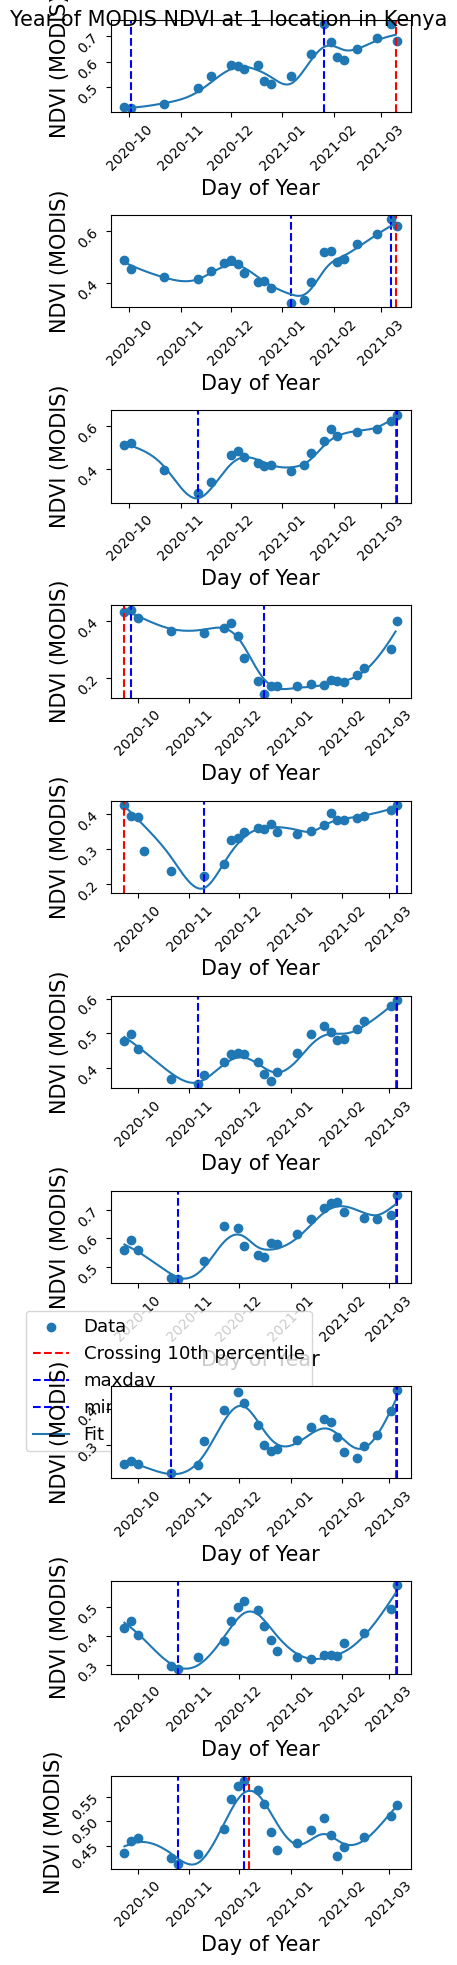

In [20]:
#ds = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\earth_engine_MP\\Saved_files\\MODIS\\Germany\\satdata0_GER.csv')
#ds = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\earth_engine_MP\\Saved_files\\MODIS\\Kenya\\satdata0_KEN.csv')#_KEN
ds = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\earth_engine_MP\\Saved_files\\Sentinel\\Kenya\\satdata0.csv')#_KEN
#ds = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\earth_engine_MP\\Saved_files\\Sentinel\\Germany\\satdata0.csv')
#ds['NDVI'] = (ds['median sur_refl_b02'] - ds['median sur_refl_b01'])/(ds['median sur_refl_b02'] + ds['median sur_refl_b01'])
ds['NDVI'] = normalized_difference(ds['median B8'], ds['median B4'])
#station = ds['Stations_Id'].unique()[0]
plot_many_NDVI_curves(ds, 2020, shift = 0, font_size = 15)




In [234]:
pd.DatetimeIndex(max_value_interpolated['time']).min() + Times.astype('timedelta64[D]') #np.timedelta64(Times, 'D')

array([Timestamp('2021-09-23 00:00:00+0000', tz='UTC'),
       Timestamp('2021-10-01 00:00:00+0000', tz='UTC'),
       Timestamp('2021-10-09 00:00:00+0000', tz='UTC'),
       Timestamp('2021-10-17 00:00:00+0000', tz='UTC'),
       Timestamp('2021-10-25 00:00:00+0000', tz='UTC'),
       Timestamp('2021-11-02 00:00:00+0000', tz='UTC'),
       Timestamp('2021-11-10 00:00:00+0000', tz='UTC'),
       Timestamp('2021-11-18 00:00:00+0000', tz='UTC'),
       Timestamp('2021-11-26 00:00:00+0000', tz='UTC'),
       Timestamp('2021-12-04 00:00:00+0000', tz='UTC'),
       Timestamp('2021-12-12 00:00:00+0000', tz='UTC'),
       Timestamp('2021-12-20 00:00:00+0000', tz='UTC'),
       Timestamp('2021-12-28 00:00:00+0000', tz='UTC'),
       Timestamp('2022-01-05 00:00:00+0000', tz='UTC'),
       Timestamp('2022-01-13 00:00:00+0000', tz='UTC'),
       Timestamp('2022-01-21 00:00:00+0000', tz='UTC'),
       Timestamp('2022-01-29 00:00:00+0000', tz='UTC'),
       Timestamp('2022-02-06 00:00:00+0000', tz=

array([  0,   8,  16,  24,  32,  40,  48,  56,  64,  72,  80,  88,  96,
       104, 112, 120, 128, 136, 144, 152, 160, 168],
      dtype='timedelta64[D]')

In [112]:
ds = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\earth_engine_MP\\Saved_files\\MODIS\\Germany\\satdata0.csv')
#ds = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\earth_engine_MP\\Saved_files\\MODIS\\Kenya\\satdata0.csv')
ds['NDVI'] = (ds['median sur_refl_b02'] - ds['median sur_refl_b01'])/(ds['median sur_refl_b02'] + ds['median sur_refl_b01'])
#station = ds['Stations_Id'].unique()[0]
latlon = ds.loc[:, ['lat', 'lon']].drop_duplicates().sample(1)
ds_station = ds.loc[(ds['lat'] == latlon['lat'].values[0]) & (ds['lon'] == latlon['lon'].values[0])]
#ds_station = ds.loc[(ds['Stations_Id'] == station)]
ds_year = ds_station.loc[pd.DatetimeIndex(ds_station['formatted_time']).year  == 2021]
max_value_interpolated = data_cleaning.map_max_value_int(ds_year, window_size=8)
Times = pd.DatetimeIndex(max_value_interpolated['formatted_time']).dayofyear.values
NDVIs = max_value_interpolated['NDVI'].values

params, _ = scipy.optimize.curve_fit(double_logistic, Times/365, NDVIs, maxfev = 10000)

c:\Users\wlwc1989\Documents\Phenology_Test_Notebooks\Satellite_Feature_Extraction\modelling_fctns.py:27: RuntimeWarning: overflow encountered in exp
  return a / (1 + np.exp(-b * (x - c))) + d / (1 + np.exp(-e * (x - f)))


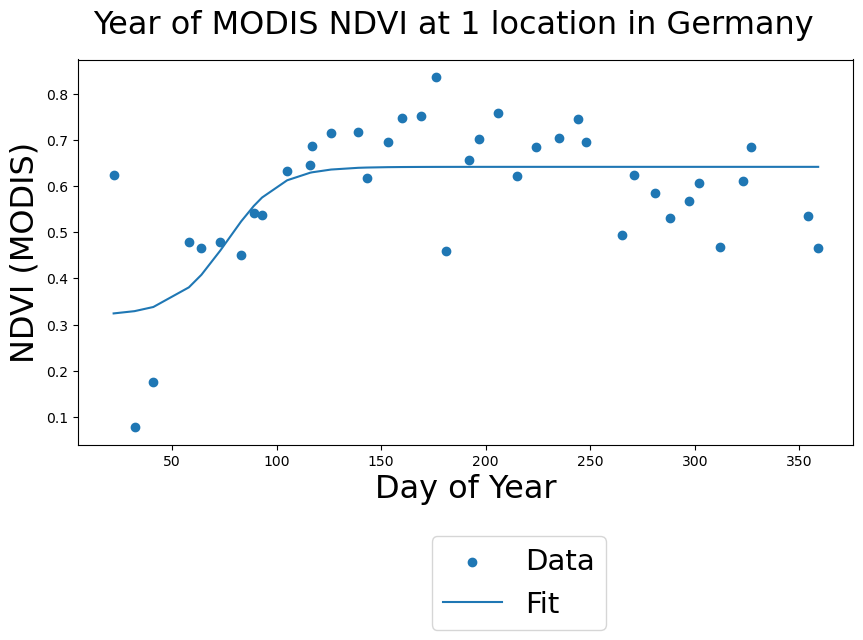

In [113]:
font_size = 23
fig, ax = plt.subplots(figsize = (10, 5))
ax.scatter(Times, NDVIs, label = 'Data')
ax.plot(Times, double_logistic(Times/365, *params), label = 'Fit')
ax.set_xlabel('Day of Year', fontsize = font_size)
ax.set_ylabel('NDVI (MODIS)', fontsize = font_size)
fig.suptitle('Year of MODIS NDVI at 1 location in Germany', fontsize = font_size)
ax.legend(fontsize = font_size - 2, bbox_to_anchor=(0.7, -0.2))

In [53]:
X = (array_input2['NDVI'] - array_input2['NDVI'].mean(dim='sample')).values
np.corrcoef(X.T)

array([[1.        , 0.83662139, 0.74261934, 0.73125136, 0.70882541],
       [0.83662139, 1.        , 0.80827924, 0.75418058, 0.65950048],
       [0.74261934, 0.80827924, 1.        , 0.76833473, 0.60545472],
       [0.73125136, 0.75418058, 0.76833473, 1.        , 0.71443907],
       [0.70882541, 0.65950048, 0.60545472, 0.71443907, 1.        ]])

In [37]:
ds2 = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\earth_engine_MP\\Saved_files\\MODIS\\Germany\\satdata0.csv')
ds2['NDVI'] = normalized_difference(ds['median sur_refl_b02'], ds['median sur_refl_b01'])
max_value_interpolated2 = data_cleaning.map_max_value_int(ds2, window_size=8)
sampled_locs_input2 = make_tensor_from_timeseries(max_value_interpolated2, sample_number = 100, m_window_size = 5, format_choice = 'numpy')

In [40]:
sampled_locs_input.shape

(95, 20)

In [51]:
np.mean(sampled_locs_input, axis=0).shape

(20,)

In [19]:
X = sampled_locs_input - np.mean(sampled_locs_input, axis=0)
Z = sampled_locs_input2 - np.mean(sampled_locs_input2, axis=0)

In [20]:
X.shape

(95, 20)

In [21]:
TCA = libtlda.tca.TransferComponentClassifier(kernel_type='sigmoid', num_components = 3)
C, K = TCA.transfer_component_analysis(X, Z)

Adding regularization: 1e-06
Adding regularization: 1e-05
Adding regularization: 0.0001
Adding regularization: 0.001
Adding regularization: 0.01
Adding regularization: 0.1
Adding regularization: 1
Adding regularization: 10
Adding regularization: 100


c:\ProgramData\anaconda3\envs\pytorch\Lib\site-packages\libtlda\tca.py:108: RuntimeWarning: overflow encountered in exp
  return 1./(1 + np.exp(np.dot(X, Z.T)))


In [26]:
adapter = adapt.feature_based.fMMD()
#X_emb.shape
adapter.fit_transform(X, Z)
adapter.transform(np.array([range(20)]))

     pcost       dcost       gap    pres   dres
 0:  0.0000e+00 -2.1000e+01  2e+01  1e+00  1e+00
 1:  9.0706e-02 -1.4078e+01  2e+01  7e-01  7e-01
 2:  1.3885e-01 -1.0046e+01  1e+01  5e-01  5e-01
 3:  8.5195e-02 -3.4231e+00  4e+00  4e-12  2e-16
 4:  8.5203e-04 -3.4231e-02  4e-02  7e-14  3e-16
 5:  8.5211e-06 -3.4231e-04  4e-04  8e-14  5e-17
 6:  8.5215e-08 -3.4231e-06  4e-06  5e-13  1e-16
 7:  8.4653e-10 -3.4233e-08  4e-08  9e-13  1e-16
Optimal solution found.


array([[17]])

In [28]:
adapter.selected_features_

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False,  True,
       False, False])

In [ ]:
plt.imshow(np.corrcoef(X.T))

In [ ]:

    #return cross_percentile_date(smoothed_series, 10), cross_percentile_date(smoothed_series, 50), cross_percentile_date(smoothed_series, 90), max_green #Tighter_times[np.int64(smoothed_series.idxmax()*365)]

In [ ]:
fd['time'] = pd.DatetimeIndex(fd['time']).dayofyear
fd = FDataGrid(
    grid_points=fd['time'],
    data_matrix=np.array([fd['NDVI'].values]),
)
latlon = ds.loc[:, ['lat', 'lon']].drop_duplicates().sample(1)
ds_station = ds.loc[(ds['lat'] == latlon['lat'].values[0]) & (ds['lon'] == latlon['lon'].values[0])]
#ds_station = ds.loc[(ds['Stations_Id'] == station)]
ds_year = ds_station.loc[pd.DatetimeIndex(ds_station['formatted_time']).year  == 2021]
max_value_interpolated = data_cleaning.map_max_value_int(ds_year, window_size=8)
fd = max_value_interpolated[['NDVI', 'formatted_time']]
fd = fd.rename(columns = {'formatted_time':'time'}).reset_index().drop(['formatted_time', 'level_1'], axis = 1)
os = NadarayaWatsonHatMatrix(bandwidth=60)
fd_os = KernelSmoother(
    kernel_estimator=os,
    output_points=np.arange(10, 350)
)
os_fitted = fd_os.fit_transform(fd)

us = NadarayaWatsonHatMatrix(bandwidth=20)
fd_us = KernelSmoother(
    kernel_estimator=us,
    output_points=np.arange(10, 350)
)
us_fitted = fd_us.fit_transform(fd)
fig, ax = plt.subplots()
ax.plot(fd_os.output_points.squeeze(), os_fitted.data_matrix.squeeze(), color = 'black', linestyle='--')
ax.plot(fd_us.output_points.squeeze(), us_fitted.data_matrix.squeeze(), color = 'black', linestyle=':')
ax.scatter(fd.grid_points, fd.data_matrix.squeeze(), color='red')